In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 28.8 MB/s 
     |████████████████████████████████| 101 kB 11.1 MB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
     |████████████████████████████████| 6.6 MB 26.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 34.3 MB/s 
     |████████████████████████████████| 212 kB 72.6 MB/s 
     |████████████████████████████████| 141 kB 73.9 MB/s 
     |████████████████████████████████| 127 kB 76.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolv

In [2]:
from tqdm import tqdm
from transformers import pipeline
from transformers import AutoModel, RobertaTokenizerFast
import numpy as np
import torch
from tqdm import tqdm
from tqdm import trange
from transformers import pipeline
from itertools import combinations
import matplotlib.pyplot as plt
import scipy
import torch
import pickle
from datasets import load_dataset
import nltk
import random
import torch.nn as nn
import sys

In [3]:
# this is the only available pre-training dataset of roberta
# other datasets are not available with the streaming option
# https://huggingface.co/docs/datasets/stream
dataset = load_dataset("stsb_multi_mt", "en", "train")

Using custom data configuration en-data_dir=train


Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dataset stsb_multi_mt downloaded and prepared to /root/.cache/huggingface/datasets/stsb_multi_mt/en-data_dir=train/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
sents = []

for d in dataset:
    for pair in dataset[d]:
        sents.append(pair["sentence1"])
        sents.append(pair["sentence2"])

print(f"Total number of sentences: {len(sents)}")

# for better batching
tokenizer = RobertaTokenizerFast.from_pretrained("princeton-nlp/sup-simcse-roberta-base")
sorted_sents = sorted(sents, key = lambda x: len(tokenizer(x)["input_ids"]))

Total number of sentences: 17256


In [5]:
# get the device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
# define cosine similarity
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

In [7]:
# the name of the saved file
save_file = "/content/drive/MyDrive/yearly-bias/results/anisotropy-SimCSE.pkl"

100%|██████████| 13/13 [01:29<00:00,  6.90s/it]


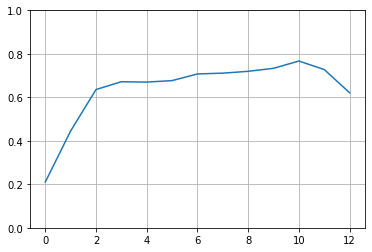

In [8]:
# total number of available layers
nol = 13

all_self_sims = []

# for reproducible sample
torch.manual_seed(42)

# do not use the masked version of AutoModel
model = AutoModel.from_pretrained("princeton-nlp/sup-simcse-roberta-base").to(device)
tokenizer = RobertaTokenizerFast.from_pretrained("princeton-nlp/sup-simcse-roberta-base")

# save embeddings of all sentences
all_embeddings = [[] for _ in range(nol)]

# the chunk size for the encoding model
chunk_size = 100

# use only part of the sentences as a very rough estimate
# results do not seem to qualitatively differ
for i in tqdm(range(0, len(sorted_sents), chunk_size)):
    chunk = sorted_sents[i: i + chunk_size]
    encoded_input = tokenizer(chunk, padding=True, return_tensors='pt').to(device)
    lens = torch.sum(encoded_input.attention_mask, dim = 1)
    with torch.no_grad():
        model_output = model(**encoded_input, output_hidden_states=True)

    # sample one word from one sentence
    s = encoded_input.attention_mask.sum(axis=1).shape
    idx = (torch.rand(s).to(device) * encoded_input.attention_mask.sum(axis=1)).long()

    for j in range(13):
        # sentence id and word id
        for si, wi in enumerate(idx):
            all_embeddings[j].append(model_output.hidden_states[j][si, wi])

# the coefficient
n = len(all_embeddings[0])
coef = (n**2 - n) / 2

self_sims = []
for j in trange(13):
    # get pairwise cosine similarity
    # matrix too large, have to put on cpu
    embs = torch.stack(all_embeddings[j]).to("cpu")
    lembs = torch.linalg.norm(embs, dim = 1)
    pcos = (embs @ embs.T) / (lembs * lembs[:,None])

    # coef terms in total
    self_sim = torch.sum(torch.triu(pcos, diagonal=1))

    self_sims.append(self_sim.item() / coef)

plt.plot(self_sims)
plt.ylim(0, 1)
plt.title("")
plt.grid()
plt.show()

# saving the data
all_self_sims.append(self_sims)

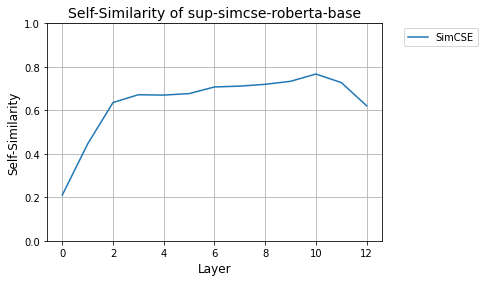

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(all_self_sims[0], label="SimCSE")

ax.set_xlabel("Layer", fontsize=12)
ax.set_ylabel("Self-Similarity", fontsize=12)
ax.set_title("Self-Similarity of sup-simcse-roberta-base", fontsize=14)
ax.set_ylim(0,1)
ax.legend(loc='upper left', bbox_to_anchor = (1.05, 1.0))
ax.grid()
plt.show()

In [10]:
with open(save_file, "wb") as f:
    pickle.dump(all_self_sims, f)